In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np

N_DENSE = 2
L=8

In [2]:
df_bins = pd.read_csv("/home/owen/repos/z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L), sep="\t")
df_conf = pd.read_csv("/home/owen/repos/z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L), delimiter=r"\s+", header=None)

In [3]:
df_bins

,# L,T,binNum,E,ESq,AccRate_local,AccRate_clust,sigma,absSigma
0,8,1,1,-1.997375,3.989828125,0.0007203125,1,0.05003125,0.99934375
1,8,1,2,-1.998,3.9922734375,0.00071953125,1,0.03378125,0.99946875
2,8,1,3,-1.996,3.9845625,0.0007496875,1,-0.03578125,0.99896875
3,8,1,4,-1.9974375,3.99008203125,0.00073109375,1,-0.09196875,0.99934375
4,8,1,5,-1.9974375,3.99008203125,0.0007084375,1,0.08396875,0.99934375
...,...,...,...,...,...,...,...,...,...
4999,8,5,996,-0.435125,0.2342109375,0.6916240625,1,0.012375,0.1696875
5000,8,5,997,-0.4463125,0.23892578125,0.6923890625,1,0.02065625,0.17459375
5001,8,5,998,-0.431,0.2245078125,0.69159796875,1,-0.00934375,0.16890625
5002,8,5,999,-0.42225,0.21940625,0.69218546875,1,-0.004875,0.1698125


In [4]:
df_bins.iloc[1000][1]

' T '

In [5]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [6]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

In [7]:
df_conf

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,-1,-1,-1,-1,1,-1,1,1
4996,1,1,1,-1,-1,1,1,1,1,1,...,-1,1,1,1,-1,-1,1,1,1,1
4997,1,1,-1,-1,1,1,-1,-1,-1,-1,...,1,-1,1,-1,-1,-1,-1,1,-1,-1
4998,1,-1,1,1,1,-1,1,-1,1,-1,...,1,1,1,-1,1,1,-1,-1,-1,-1


In [8]:
df_conf["T"] = df_bins[" T "]

In [9]:
filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
#filterned_confs = df_conf

In [10]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,T
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.0


In [11]:
img_pca = PCA(n_components=N_DENSE)

In [12]:
img_pca.fit(filterned_confs.drop("T", axis=1).sample(frac=1))

PCA(n_components=2)

In [13]:
components = img_pca.transform(filterned_confs.drop("T", axis=1))

In [14]:
components.shape

(1996, 2)

In [15]:
filterned_confs["T"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4995    5.0
4996    5.0
4997    5.0
4998    5.0
4999    5.0
Name: T, Length: 1996, dtype: float64

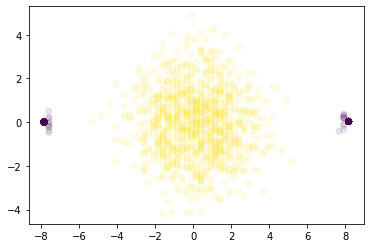

In [16]:
plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)

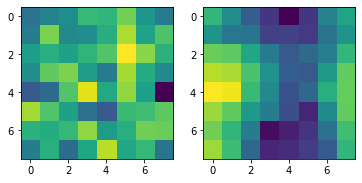

In [17]:
fig_pca, axes_pca = plt.subplots(1,N_DENSE)
for i, ax in enumerate(axes_pca.flat):
    ax.imshow(img_pca.components_[i].reshape(L,L))

In [18]:
df_components = pd.DataFrame(data={"c0": components[:,0], "c1": components[:,1], "T": pd.to_numeric(filterned_confs["T"])})

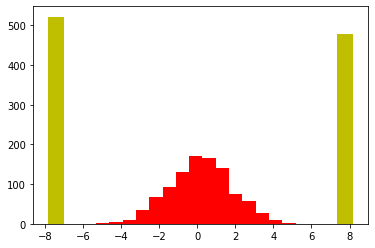

In [31]:
component_number = 0
plt.hist(df_components[df_components["T"] > 2]["c{}".format(component_number)], bins=15, color="r")
plt.hist(df_components[df_components["T"] < 2]["c{}".format(component_number)], bins=20, color="y")
plt.show()